 ## Musical Analysis of 10,000 Songs
    
    by Varun Nadgir

## Milestone Report

### The Problem & Client

Although this problem has already been explored extensively by companies such as Soundcloud, Spotify, YouTube, and iTunes, I would like to personally tackle music classification and recommendation. My client(s) would be the collective userbases of the aforementioned services and others like them - people that are looking for new music. Since there are so many such services, the ones with the best recommendations will the most successful at retaining customers. I would like to act as if I were a data scientist for one of these companies and see what methods I can use to offer good suggestions to users. Using clustering to do some basic recommendations will be a good starting point, and I will also try to run some text analysis on the words/phrases that come up in artist names/song titles/album titles and see which ones show up the most by genre.

### The Data

I will be working with a subset of the [Million Songs Dataset](https://think.cs.vt.edu/corgis/csv/music/music.html). The features include things such as key signature, time signature, duration, loudness, "hotness" of the track, and more. Some of these stats also have confidence measures associated with them, so it may be worthwhile to run the analysis again on a more "confident" subset to see if the results are any different from the full 10,000 songs.

### Importing Data

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# read in csv
musicdf = pd.read_csv('songs.csv')

In [2]:
musicdf.head()

,artist_hotness,artist_id,artist_name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


### Data Wrangling

##### Artist Clustering

In [31]:
# subset certain columns
cluster_cols = ['artist_name', 'duration', 'key', 'mode', 'tempo', 'time_signature', 'loudness']
df = musicdf[cluster_cols]

# remove outlier
df = df.drop(6348)

# turn categorical variables into appropriate dummy variables
df_dummies = pd.get_dummies(df, prefix=['key', 'mode', 'time_signature'], columns=['key', 'mode', 'time_signature'])

df_dummies.head()

,artist_name,duration,tempo,loudness,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,...,key_10.0,key_11.0,mode_0,mode_1,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,time_signature_7.0
0,Casual,218.93179,92.198,-11.197,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,The Box Tops,148.03546,121.274,-9.843,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,Sonora Santanera,177.47546,100.070,-9.689,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,Adam Ant,233.40363,119.293,-9.013,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,Gob,209.60608,129.738,-4.501,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [29]:
# prepare artist names and averages by artist
artists = df_dummies['artist_name'].unique()

# group features by artist
grouped_dummies = df_dummies.groupby('artist_name')

avgs = []

for artist in artists:
    avgs.append(grouped_dummies.get_group(artist).mean().values)

In [30]:
# create dataframe
avgs_df = pd.DataFrame(avgs, index=artists, columns=df_dummies.columns[1:24])

avgs_df.head()

,duration,tempo,loudness,key_0.0,key_1.0,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,...,key_10.0,key_11.0,mode_0,mode_1,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,time_signature_7.0
Casual,222.445261,105.765875,-8.589875,0.125,0.125,0.125,0.0,0.375,0.0,0.00,...,0.125,0.125,0.375,0.625,0.0,0.25,0.00,0.625,0.125,0.0
The Box Tops,154.102402,110.799750,-11.062500,0.250,0.000,0.000,0.0,0.250,0.0,0.25,...,0.000,0.000,0.250,0.750,0.0,0.25,0.25,0.500,0.000,0.0
Sonora Santanera,166.092608,101.017500,-11.321250,0.250,0.000,0.500,0.0,0.000,0.0,0.00,...,0.000,0.000,0.500,0.500,0.0,0.50,0.00,0.250,0.250,0.0
Adam Ant,214.067792,123.424800,-8.476800,0.400,0.200,0.000,0.0,0.000,0.0,0.00,...,0.000,0.000,0.000,1.000,0.0,0.00,0.00,1.000,0.000,0.0
Gob,181.472200,131.862000,-5.210500,0.000,0.000,0.500,0.0,0.500,0.0,0.00,...,0.000,0.000,0.000,1.000,0.0,0.00,0.00,1.000,0.000,0.0


With the averages, we can then cluster based on which artists have similar musical structures. The values will need to be normalized for proper modeling. This dataframe can also be used for some basic EDA to compare occurrences of the key/time signatures, as well as the relationship between features like duration and tempo.

This same method can also be applied to other groupings, such as averages across genres or locations where the albums were recorded. Some sort of mix of this would be a great way to recommend songs to people based on multiple factors.

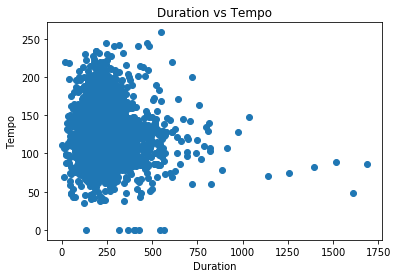

In [35]:
# EDA example
plt.title('Duration vs Tempo')
plt.xlabel('Duration')
plt.ylabel('Tempo')
plt.scatter(avgs_df['duration'], avgs_df['tempo'])

plt.show()

##### Genre Analysis

In this dataset, there are over 400 genres listed. After applying clustering to the genres, we can also reduce the number of genres into a smaller number of umbrella terms. I would then like to collect all of the terms used in artist names, album titles, and song titles to come up with the most common terminology of each genre. 

In [37]:
genres = musicdf['terms'].unique()

print(len(genres))

459


### Potential for the Future

Once this analysis is complete, it can be applied to the full 300 GB dataset. The entire dataset is enormous, so I may need to use cloud computing or a stronger physical computer, but it would certainly be interesting and should have more accurate results. Also, it would be interesting to apply user data to a dataset like this, i.e. user IDs and user ratings so that recommendations can be personalized.